<a href="https://www.kaggle.com/code/yannicksteph/dnn-wine-prediction?scriptVersionId=138890474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# | DNN | WINE | Prediction |
## Dense Neural Network (DNN) for Wine quality Prediction

# <b>1. <span style='color:#78D118'>|</span> Introduction</b>

In this notebook, we employ a Dense Neural Network (DNN) to perform a prediction task on the renowned Wine Quality dataset.

The [Wine Quality dataset](https://archive.ics.uci.edu/ml/datasets/wine+Quality), comprised of extensive wine analyses, assigns each wine a quality score between 0 and 10. Credit for the dataset goes to [Paulo Cortez](http://www3.dsi.uminho.pt/pcortez) from the University of Minho, Guimarães, Portugal. You can access this dataset from the [University of California Irvine (UCI) Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality).

The dataset, due to privacy and logistical issues, only contains physicochemical and sensory variables. Aspects such as grape types, wine brands, and selling prices are excluded. The dataset includes the following features:

- Fixed acidity
- Volatile acidity
- Citric acid
- Residual sugar
- Chlorides
- Free sulfur dioxide
- Total sulfur dioxide
- Density
- pH
- Sulphates
- Alcohol
- Quality (score between 0 and 10)

The notebook is structured into the following sections:

## Objective:
- Our primary aim is to predict wine quality based on the provided analysis data using a simple Dense Neural Network (DNN).
- Testing the a simple DNN model.
- The aim is not only to achieve high predictive accuracy but also to create a model that is computationally efficient and easily interpretable, offering valuable insights into the relationships between physicochemical properties and wine quality.

## Steps:
1. **Imports, Constants, & Methods**: Set up the necessary libraries, constants, and methods for the task.
2. **Data Retrieval**: Fetch the Wine Quality dataset from the provided source.
3. **Data Preparation**: Conduct necessary preprocessing and data cleaning activities on the dataset.
4. **Model Creation**: Design and establish a Dense Neural Network (DNN) for predicting wine quality.
5. **Model Training & Saving**: Train the DNN on the prepared dataset and store the trained model for future reference.
6. **Model Evaluation**: Gauge the performance of the trained model by evaluating its predictions against the test data.
7. **Best Model Evaluation & Prediction**: Assess the performance of the best model saved during training, by evaluating its predictions on test data. And Use the best-trained model to generate predictions on new, unseen wine data.

# <b>2. <span style='color:#78D118'>|</span> Imports & Constants</b>

## <b>2.1. <span style='color:#78D118'>|</span> Imports</b>

In [61]:
!pip install -q git+https://github.com/YanSteph/SKit.git@0.0.3
!pip install -q visualkeras

In [62]:
# Importing Standard Libraries
import os
import sys

# Importing Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras for Machine Learning
import tensorflow as tf
from tensorflow import keras

# Importing IPython specific libraries for interactive output
from IPython.display import Markdown

# These are the Python's built-in libraries. They are generally used for importing modules dynamically
from importlib import reload

# Importing libraries for Visualizing the model
import visualkeras

# Smartkit is a third-party library that provides various utilities to help make machine learning easier. 
# show_history and show_confusion_matrix are used to visualize the training history and confusion matrix respectively.
from smartkit.show import show_history, show_confusion_matrix

Verbosity during training:
- 0: Silent mode, no output will be displayed during training.
- 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
- 2: One line per epoch mode, a concise summary will be displayed for each epoch.

For the current training configuration:
- Batch size: Which determines the number of samples processed in each training iteration.
- Number of epochs: Indicating the total number of times the model will be trained on the entire dataset.


## <b>2.2. <span style='color:#78D118'>|</span> Contants</b>

In [63]:
dataset_path  = '/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'

In [64]:
batch_size = 16
epochs = 50
seed = 123
fit_verbosity = 1

## <b>3. <span style='color:#78D118'>|</span> Retrieve data</b>

In [65]:
data = pd.read_csv(dataset_path, header=0,sep=',')

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data :  0   Shape is :  (1599, 12)


# <b>3. <span style='color:#78D118'>|</span> Preparing the data</b>

To prepare the data for training and validation, we will split it into two parts: 80% for training and 20% for validation and doing some normalization

## <b>3.1. <span style='color:#78D118'>|</span> Splitting</b>

The feature data, representing the analysis variables, will be denoted as 'x', while the target variable, indicating the wine quality, will be denoted as 'y'.

In [66]:
# train, test
#
np.random.seed(seed)
data = data.sample(frac=1., axis=0)           # Shuffle        
data_train = data.sample(frac=0.8, axis=0)    # get 80%
data_test = data.drop(data_train.index)       # test = all - train

# x, y (quality is the target variable)
#
x_train = data_train.drop('quality', axis=1)
y_train = data_train['quality']
x_test = data_test.drop('quality', axis=1)
y_test = data_test['quality']
shape = x_train.shape[1]

print('Original data shape was:', data.shape)
print('x_train:', x_train.shape, 'y_train:', y_train.shape)
print('x_test:', x_test.shape, 'y_test:', y_test.shape)
print('Shape:', shape)

Original data shape was: (1599, 12)
x_train: (1279, 11) y_train: (1279,)
x_test: (320, 11) y_test: (320,)
Shape: 11


## <b>3.2. <span style='color:#78D118'>|</span> Normalization</b>

**Note:**
- It is important to normalize all input data, including both the training and testing datasets.
- For normalization, we will subtract the mean and divide by the standard deviation.
- However, it is crucial to avoid using the test data for any calculations, including normalization.
- Therefore, the mean and standard deviation will only be calculated based on the training data.

In [67]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()

x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.30,0.53,0.27,2.54,0.09,15.99,46.64,1.00,3.31,0.66,10.41
std,1.74,0.18,0.19,1.42,0.05,10.38,32.54,0.00,0.15,0.17,1.06
min,4.70,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.10,1.90,0.07,8.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.10
75%,9.20,0.63,0.42,2.60,0.09,21.50,63.00,1.00,3.41,0.73,11.10
max,15.60,1.58,1.00,15.50,0.61,72.00,278.00,1.00,4.01,2.00,14.00


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.07,-2.25,-1.41,-1.15,-1.56,-1.44,-1.25,-3.47,-3.74,-1.94,-1.89
25%,-0.69,-0.75,-0.89,-0.45,-0.36,-0.77,-0.76,-0.60,-0.68,-0.65,-0.86
50%,-0.23,-0.03,-0.07,-0.24,-0.18,-0.19,-0.27,-0.00,-0.02,-0.23,-0.29
75%,0.52,0.58,0.76,0.05,0.05,0.53,0.50,0.58,0.63,0.42,0.65
max,4.20,5.85,3.76,9.12,10.77,5.39,7.11,3.60,4.54,7.91,3.39


## <b>4. <span style='color:#78D118'>|</span> Build a model</b>

More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [68]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape, name="InputLayer"))
model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
model.add(keras.layers.Dense(1, name='Output'))

model.compile(
    optimizer = 'rmsprop',
    loss = 'mse',
    metrics = ['mae', 'mse']
)

# <b>5. <span style='color:#78D118'>|</span> Train the model</b>

## <b>5.1. <span style='color:#78D118'>|</span> Summary</b>

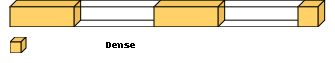

In [69]:
visualkeras.layered_view(model, legend=True, scale_z=1, scale_xy =20, spacing=80)

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


## <b>5.2. <span style='color:#78D118'>|</span> Callback</b>

In [71]:
os.makedirs('./models', mode=0o750, exist_ok=True)
save_dir = "./models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

## <b>5.3. <span style='color:#78D118'>|</span> Train</b>

In [72]:
history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/50
80/80 [==============================] - 1s 6ms/step - loss: 10.6826 - mae: 2.7221 - mse: 10.6826 - val_loss: 2.3860 - val_mae: 1.2510 - val_mse: 2.3860
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 1.9115 - mae: 1.0695 - mse: 1.9115 - val_loss: 1.5643 - val_mae: 1.0015 - val_mse: 1.5643
Epoch 3/50
80/80 [==============================] - 0s 5ms/step - loss: 1.2714 - mae: 0.8788 - mse: 1.2714 - val_loss: 1.2411 - val_mae: 0.8867 - val_mse: 1.2411
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.9551 - mae: 0.7540 - mse: 0.9551 - val_loss: 0.9812 - val_mae: 0.7552 - val_mse: 0.9812
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 0.7533 - mae: 0.6691 - mse: 0.7533 - val_loss: 0.7272 - val_mae: 0.6504 - val_mse: 0.7272
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6034 - mae: 0.6117 - mse: 0.6034 - val_loss: 0.7089 - val_mae: 0.6313 - val_mse: 0.7089
Epoch 7/50
80/80 [========

# <b>6. <span style='color:#78D118'>|</span> Evaluate</b>


- **Loss**: This is the total error of the model, calculated using the cost function specified when compiling the model. A value closer to 0 indicates better model performance.
  
- **MAE (Mean Absolute Error)**: This is the average of the absolute errors between the predictions and the true values. A lower MAE is better as it means the model's predictions are closer to the actual values. 
  
- **MSE (Mean Squared Error)**: This is the average of the squares of the errors between the predictions and the true values. Like the others, a value closer to 0 is better. An MSE higher than MAE may indicate the presence of significant errors or outliers, as these are amplified by the squaring.

In [73]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.4294
x_test / mae       : 0.4791
x_test / mse       : 0.4294


- **Validation Mean Absolute Error** : This is the average of the absolute differences between the predictions of the model and the true values in the validation dataset. A lower validation MAE is better, as it means that the model's predictions are closer to the actual values.

In [74]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.4628


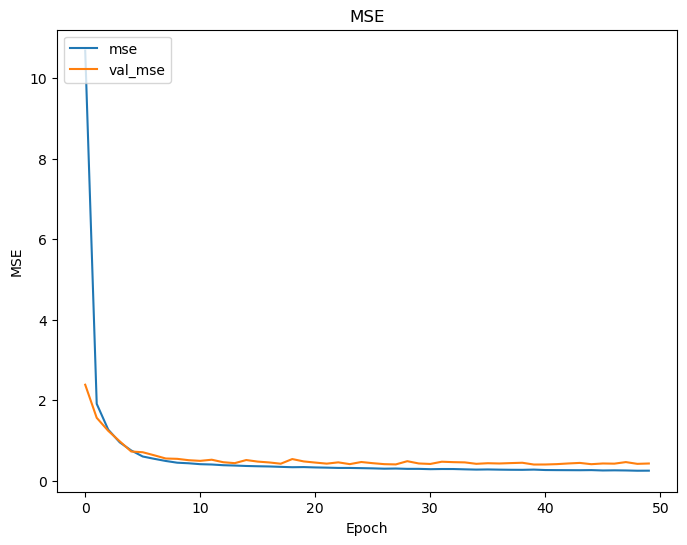

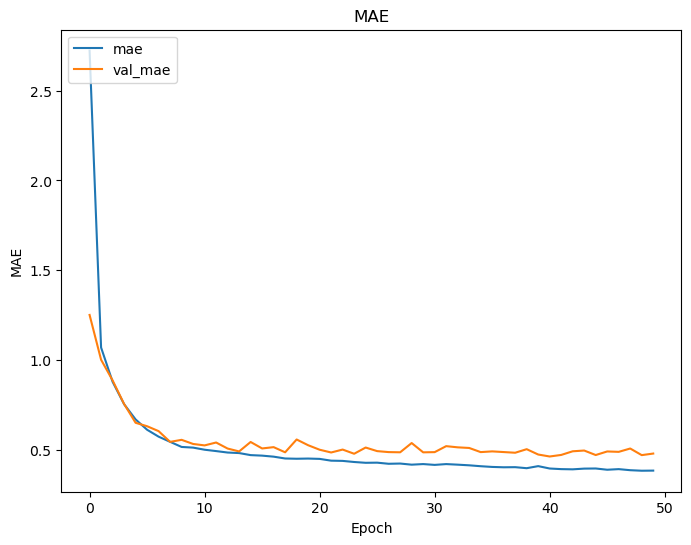

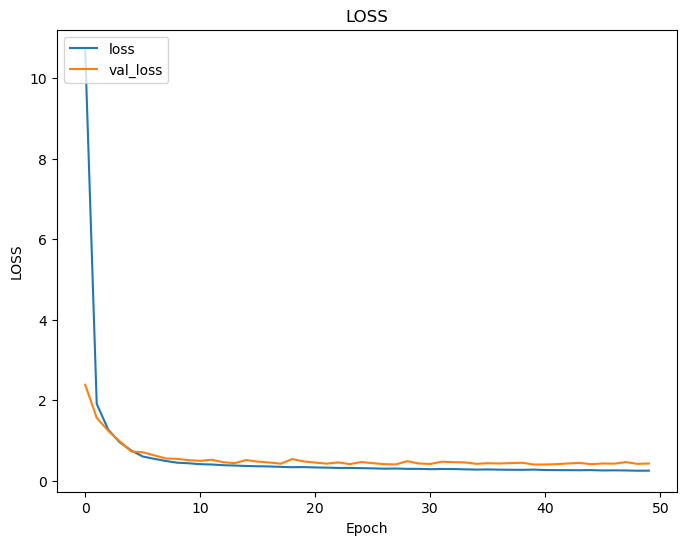

In [75]:
show_history( 
    history, 
    plot={
        'MSE' :['mse', 'val_mse'],
        'MAE' :['mae', 'val_mae'],
        'LOSS':['loss','val_loss']
    })

During our training, the best result achieved was a low training loss and a low validation loss. However, we observed that there was overfitting in the model.

Overfitting occurs when the model performs well on the training data but fails to generalize well to unseen data. It often results in a large gap between the training loss and the validation loss. In our case, we noticed that the model's performance on the training data was significantly better than its performance on the validation data, indicating overfitting.

During the training process, we implemented a callback mechanism to save the best-performing model. The callback monitored the validation loss during each epoch and automatically saved the model when it achieved the lowest validation loss.

By saving the best model, we ensured that we captured the model's parameters at the point where it exhibited the highest level of accuracy on the validation data. This allows us to use this saved model for future predictions or further analysis, confident that it represents the model with the best performance during the training process.

# <b>7. <span style='color:#78D118'>|</span> Evaluate the best model</b>

## <b>7.1. <span style='color:#78D118'>|</span> Reload</b>

In [76]:
loaded_model = tf.keras.models.load_model('./models/best_model.h5')
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


## <b>7.2. <span style='color:#78D118'>|</span> Evaluate</b>

In [77]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f}'.format(score[0]))
print('x_test / mae : {:5.4f}'.format(score[1]))
print('x_test / mse : {:5.4f}'.format(score[2]))

x_test / loss : 0.4037
x_test / mae : 0.4738
x_test / mse : 0.4037


## <b>7.3. <span style='color:#78D118'>|</span> Prediction</b>

In [78]:
# Pick n entries from our test set
n = 200
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [79]:
# Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

7/7 - 0s - 57ms/epoch - 8ms/step


In [80]:
# Show it
print('Wine    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Wine    Prediction   Real   Delta
000        5.17       5      -0.17 
001        6.19       6      -0.19 
002        5.82       6      +0.18 
003        5.79       5      -0.79 
004        5.34       6      +0.66 
005        7.02       6      -1.02 
006        6.02       6      -0.02 
007        6.79       7      +0.21 
008        6.42       7      +0.58 
009        4.89       5      +0.11 
010        4.98       5      +0.02 
011        5.63       5      -0.63 
012        5.37       5      -0.37 
013        4.98       5      +0.02 
014        6.16       6      -0.16 
015        5.64       5      -0.64 
016        5.32       5      -0.32 
017        5.18       5      -0.18 
018        7.02       7      -0.02 
019        5.48       5      -0.48 
020        5.74       6      +0.26 
021        5.37       5      -0.37 
022        5.24       5      -0.24 
023        5.84       5      -0.84 
024        6.00       6      -0.00 
025        5.45       5      -0.45 
026        7.21       7      -

## References

The creation of this document was greatly influenced by the following key sources of information:

1. Cerdeira, A., Almeida, F., Matos, T., & Reis, J., Viticulture Commission of the Vinho Verde Region (CVRVV), Porto, Portugal, 2009. The [Wine Quality datasets](https://archive.ics.uci.edu/ml/datasets/wine+Quality) available at the [University of California Irvine (UCI) Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/wine+quality) were an invaluable resource.
2. [Paulo Cortez](http://www3.dsi.uminho.pt/pcortez), University of Minho, Guimarães, Portugal. His contributions to the field and online resources were a significant source of information and learning material.
3. [Fidle](https://gricad-gitlab.univ-grenoble-alpes.fr/talks/fidle/-/wikis/home) - An informative guide that provides in-depth explanations and examples on various data science topics.